In [1]:
import actionet
import actionet.preprocessing
import actionet.tools
import scipy
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
from anndata import AnnData

In [2]:
import matplotlib.pyplot as plt

In [3]:
# X = scipy.io.mmread("data/counts.mtx")
# obs_df = pd.read_csv("data/sample_data.tsv", sep="\t", header=0)
# var_df = pd.read_csv("data/feature_data.tsv", sep="\t", header=0)

In [4]:
# adata = anndata.AnnData(
#     X=scipy.sparse.csr_matrix(X).T,
#     var=var_df,
#     obs=obs_df
# )
# adata.write_h5ad("../data/test_adata.h5ad")

In [5]:
adata = anndata.read_h5ad("../data/test_adata.h5ad")

In [6]:
adata = actionet.preprocessing.filter_anndata(adata, min_cells_per_feat=0.01, inplace=False)

In [7]:
adata.layers['logcounts'] = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)['X']
sc.pp.log1p(adata, layer='logcounts', base=2, copy=False)

In [8]:
actionet.reduce_kernel(adata, n_components=30, layer='logcounts', key_added='action', inplace=True)

Computing reduced ACTION kernel:
Performing SVD using IRLB (sparse) -- A: 14409 x 6790


In [9]:
# labels = adata.obs['CellLabel'].astype('category')
# colors = labels.cat.codes  # Convert categories to integers
#
# plt.scatter(
#     x=adata.obsm['action'][:, 0],
#     y=adata.obsm['action'][:, 1],
#     c=colors,
#     cmap='tab10',  # or another categorical colormap
#     alpha=0.7,
#     s = 5
# )
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Scatter Plot Colored by Label')
# plt.colorbar(label='CellLabel')
# plt.show()

In [10]:
adata2 = actionet.run_action(adata, k_min=2, k_max=30, reduction_key='action', n_threads=0, inplace=False, prenormalize=True)

Running ACTION (14 threads):
	Iterating from k = 2 ... 30: 29/29 finished
Joining trace of C & H matrices (depth = 30) ... done (464 archetypes)
Pruning archetypes:
	Non-specific archetypes: 4
	Unreproducible archetypes: 64
	Trivial archetypes: 1
Merging 395 archetypes:
Archetypes in merged set: 24


In [11]:
adata2.obsm['H_merged']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00115602],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00367587],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10955294],
       [0.        , 0.67799282, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12817285, 0.        , ..., 0.00211534, 0.        ,
        0.        ]], shape=(6790, 24))

In [12]:
actionet.run_action(adata, k_min=2, k_max=30, reduction_key='action', n_threads=0, inplace=True, prenormalize=True)

Running ACTION (14 threads):
	Iterating from k = 2 ... 30: 29/29 finished
Joining trace of C & H matrices (depth = 30) ... done (464 archetypes)
Pruning archetypes:
	Non-specific archetypes: 4
	Unreproducible archetypes: 64
	Trivial archetypes: 1
Merging 395 archetypes:
Archetypes in merged set: 24


In [13]:
adata.obsm['H_merged']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00115602],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00367587],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10955294],
       [0.        , 0.67799282, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12817285, 0.        , ..., 0.00211534, 0.        ,
        0.        ]], shape=(6790, 24))

In [14]:
actionet.build_network(
    adata,
    obsm_key="H_stacked",
    algorithm="k*nn",
    distance_metric="jsd",
    mutual_edges_only=True,
    key_added="actionet",
    n_threads=0, inplace=True
)

Building adaptive network (density = 1.00)
	Building index ... done
	Identifying nearest neighbors ... done
	Constructing adaptive-nearest neighbor graph ... done
	Finalizing network ... done


In [15]:
adata.obsp['actionet'].sum(axis=0)

matrix([[128.21669392,  75.63541934, 156.38784122, ...,  62.17666885,
         140.89347205, 173.41478491]], shape=(1, 6790))

In [16]:
actionet.compute_network_diffusion(
    adata,
    scores=adata.obsm['H_merged'],
    norm_method='pagerank',
    network_key="actionet",
    n_threads=0,
    alpha=0.85,
    key_added="archetype_footprint",
    inplace = True
)

In [17]:
# adata.obsm['archetype_footprint']
# adata.obsm['H_merged']

In [18]:
actionet.layout_network(
    adata,
    network_key='actionet',
    initial_coords=actionet.tools.scale(adata.obsm['archetype_footprint']),
    # initial_coords=None,
    layer='logcounts',
    method='umap',
    n_components=2,
    spread=1.0,
    min_dist=1.0,
    n_epochs = 100,
    seed=0,
    key_added='umap', inplace=True
)

Optimizing layout using method 'umap': 2 components 
UMAP embedding parameters a = 0.115, b = 1.929, gamma = 1.000
Optimizing for 100 epochs with 14 threads 
Optimizing with Adam:
	 alpha = 1.000,  beta1 = 0.500, beta2 = 0.900, eps = 1.000e-07
Optimization finished


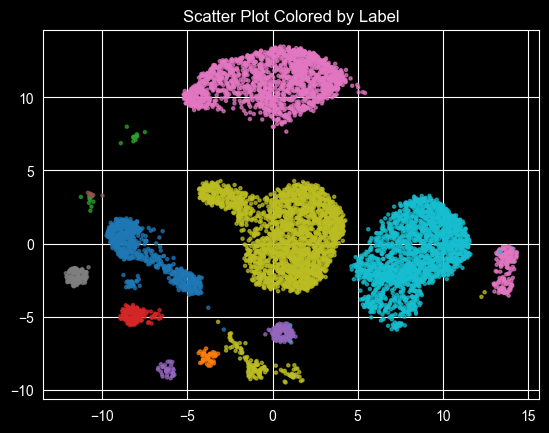

In [19]:
labels = adata.obs['CellLabel'].astype('category')
colors = labels.cat.codes  # Convert categories to integers

plt.scatter(
    x=adata.obsm['umap'][:, 0],
    y=adata.obsm['umap'][:, 1],
    c=colors,
    cmap='tab10',  # or another categorical colormap
    alpha=0.7,
    s = 5
)
# plt.xlabel('X')
# plt.ylabel('Y')
plt.title('Scatter Plot Colored by Label')
# plt.colorbar(label='CellLabel')
plt.show()

In [20]:
adata.var

,ENSEMBL,Gene,Chromosome,Biotype
0,ENSMUSG00000051951,Xkr4,1,protein_coding
1,ENSMUSG00000089699,Gm1992,1,antisense
4,ENSMUSG00000025900,Rp1,1,protein_coding
8,ENSMUSG00000033845,Mrpl15,1,protein_coding
9,ENSMUSG00000025903,Lypla1,1,protein_coding
...,...,...,...,...
32182,ENSMUSG00000063897,CAAA01118383.1,GL456216.1,protein_coding
32187,ENSMUSG00000095500,AC132444.5,GL456221.1,protein_coding
32192,ENSMUSG00000051412,Vamp7,GL456233.1,protein_coding
32195,ENSMUSG00000079834,Tmlhe,GL456233.1,protein_coding


In [21]:
markers = actionet.find_markers(adata, adata.obs['CellLabel'], features_use="Gene", top_genes=30, return_type='dataframe')

Computing feature specificity ... done


In [22]:
annots_out = actionet.annotate_cells(adata, markers.to_dict(), layer = 'logcounts', method='vision', features_use='Gene', net_key='actionet', use_enrichment=True, use_lpa=False, n_threads=0)

In [23]:
adata.obs['annot'] = annots_out['labels']
adata.obs['annot_conf'] = annots_out['confidence']
adata.obsm['annot_enrichment'] = annots_out['enrichment']

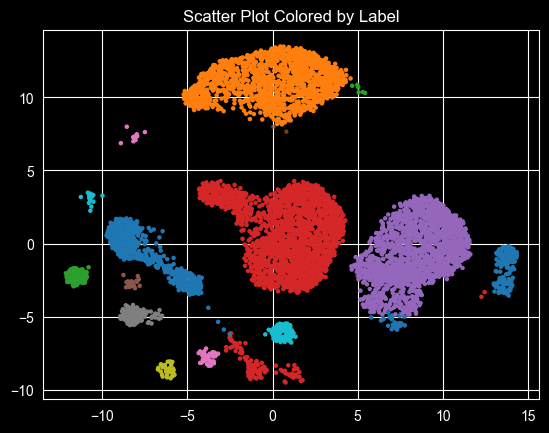

In [24]:
labels = pd.Series(annots_out['labels']).astype('category')
colors = labels.cat.codes  # Convert categories to integers

plt.scatter(
    x=adata.obsm['umap'][:, 0],
    y=adata.obsm['umap'][:, 1],
    c=colors,
    cmap='tab10',  # or another categorical colormap
    alpha=np.clip(annots_out['confidence'], 0, 1.0),
    s = 5
)
# plt.xlabel('X')
# plt.ylabel('Y')
plt.title('Scatter Plot Colored by Label')
# plt.colorbar(label='CellLabel')
plt.show()

In [25]:
adata.obsm['annot_enrichment']

array([[ 0.84692221,  5.16957668,  2.01301117, ...,  0.94684403,
        -0.62910251,  0.27810869],
       [ 0.54361674,  4.38639992,  1.33457536, ...,  0.70440643,
        -0.73441925,  0.20820462],
       [ 0.83209428,  5.46601227,  2.48789602, ...,  1.66506246,
        -0.68291121,  0.40855551],
       ...,
       [ 0.45073863,  3.14923505,  1.18233359, ...,  0.79670387,
        -0.48084829,  0.06167929],
       [ 3.30512377,  2.44421903, 27.74789117, ...,  1.1455623 ,
         1.13382587,  1.3821365 ],
       [ 3.36968475,  2.54875422, 29.16656976, ...,  1.32589484,
         0.74016857,  1.18187583]], shape=(6790, 16))

In [26]:
# adata.write_h5ad("../data/test_adata_post_annot.h5ad")

In [27]:
markers.to_csv("../data/test_markers.csv", sep=',', header=True, index=False)